In [13]:
import h5py
import numpy as np
import os
import glob
from tqdm import tqdm

In [14]:
path = r"C:\Users\GAI\Desktop\NCA_workspace\01-lbm-2d\output\Hyper\h5_SimData\hybrid_adv_L100_0000_Re1000_hybrid_adv_L100_0000.h5"
with h5py.File(path, 'r') as f:
    # 1. 查看根目錄下的所有 Key (類似 ls)
    print(f"Keys in H5: {list(f.keys())}")
    
    # 2. 取得 Dataset 物件 (此時尚未載入記憶體)
    ds = f['mean_field']
    print(f"Dataset Shape: {ds.shape}, Dtype: {ds.dtype}")
    
    # 3. 真正將數據載入成 NumPy Array
    # 使用 [:] 讀取全部，或使用切片讀取部分
    arr_full = f['mean_field'][:] 
    arr_sub = f['mean_field'][:10, :10] # 只讀取前 10x10，極省記憶體

    # 2. 取得 Dataset 物件 (此時尚未載入記憶體)
    ds = f['snapshots']
    print(f"Dataset Shape: {ds.shape}, Dtype: {ds.dtype}")
    arr_full = f['snapshots'][:] 
    arr_sub = f['snapshots'][:10, :10] # 只讀取前 10x10，極省記憶體
    

Keys in H5: ['mean_field', 'snapshots']
Dataset Shape: (9, 104, 512), Dtype: float32
Dataset Shape: (466, 9, 104, 512), Dtype: float32


原始樣本數: 466 -> 抽樣後樣本數: 10


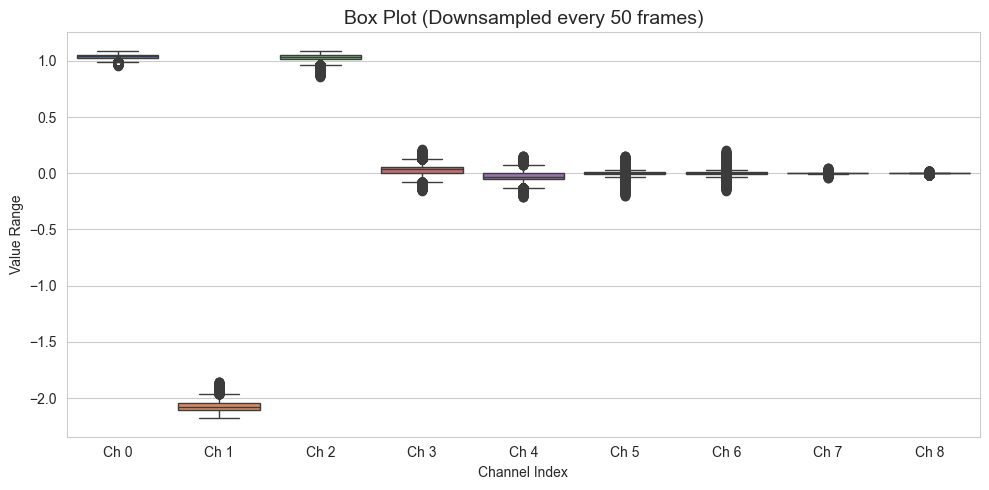

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_downsampled_h5_boxplot(file_path: str, stride: int = 50):
    """
    以步進方式讀取 H5，降低記憶體佔用並繪製 Box Plot
    """
    with h5py.File(file_path, 'r') as f:
        # 指向 Dataset (Lazy Loading)
        ds = f['snapshots'] # Shape: (466, 9, 104, 512)
        
        # --- 關鍵步驟：使用切片 [::stride, ...] ---
        # 這會直接從硬碟讀取第 0, 50, 100... 幀
        downsampled_data = ds[::stride, :, :, :] 
        
        # 確認抽樣後的形狀
        # (10, 9, 104, 512) - 466/50 向上取整
        n, c, h, w = downsampled_data.shape
        print(f"原始樣本數: {ds.shape[0]} -> 抽樣後樣本數: {n}")

        # 準備繪圖
        plot_data = []
        for i in range(c):
            # 針對每個 Channel 展平數據
            # 展平後的長度：10 * 104 * 512 = 532,480 個點
            channel_slice = downsampled_data[:, i, :, :].flatten()
            plot_data.append(channel_slice)

        # 繪圖邏輯
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=plot_data, palette="muted", showfliers=True)
        
        plt.title(f"Box Plot (Downsampled every {stride} frames)", fontsize=14)
        plt.xlabel("Channel Index")
        plt.ylabel("Value Range")
        plt.xticks(ticks=range(c), labels=[f"Ch {i}" for i in range(c)])
        plt.tight_layout()
        plt.show()

# 呼叫函數
plot_downsampled_h5_boxplot(path, stride=50)

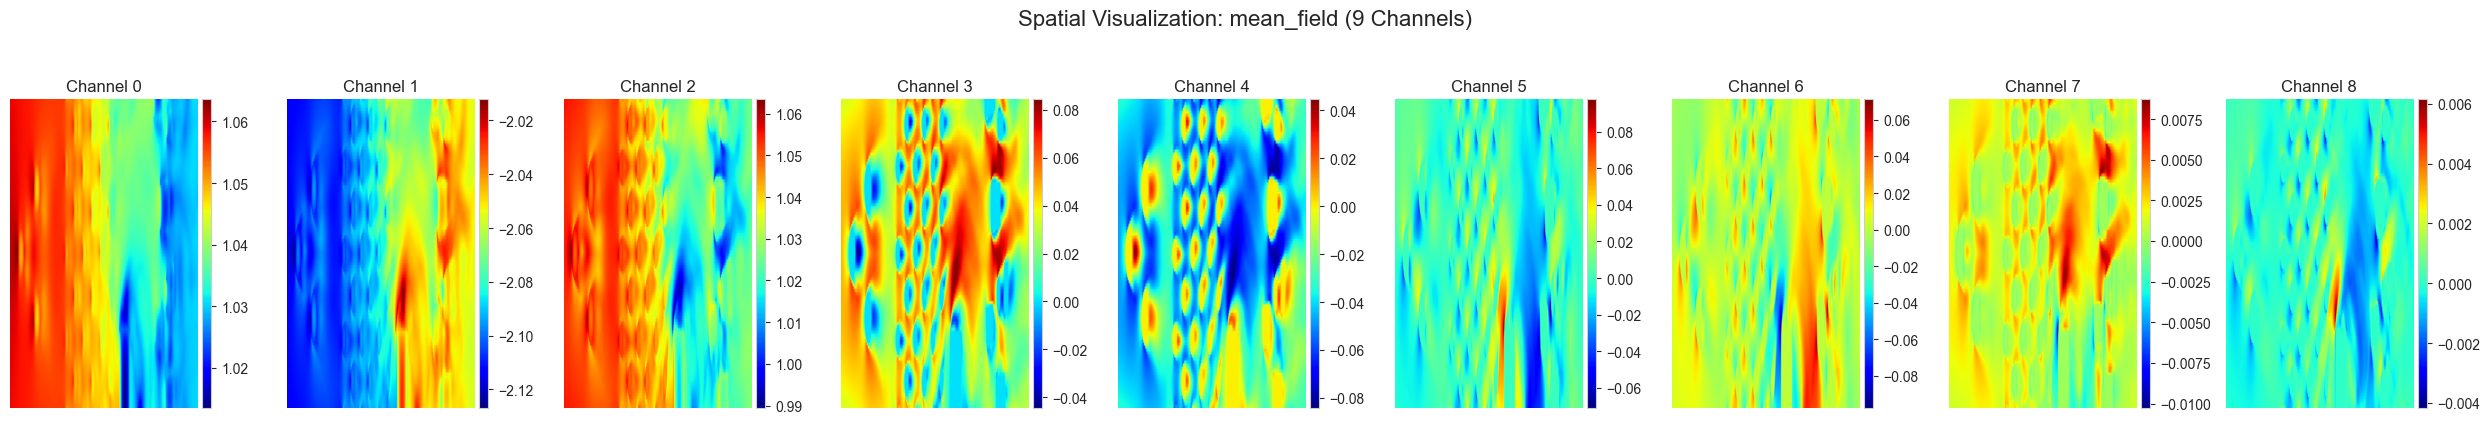

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_channels_horizontal(file_path: str, dataset_key: str = 'mean_field'):
    """
    將 9 個 Channel 以 'jet' 色階水平並排顯示
    """
    with h5py.File(file_path, 'r') as f:
        # 讀取數據: (9, 104, 512)
        data = f[dataset_key][()] 
        num_channels, height, width = data.shape

    # 1. 建立畫布: 1 列, num_channels 欄
    # 調整 figsize 比例 (寬度設大一點，高度設小)
    fig, axes = plt.subplots(num_channels,1, figsize=(25, 4))
    
    # 如果只有一個 channel，axes 會不是 list，需轉換
    if num_channels == 1:
        axes = [axes]

    for i in range(num_channels):
        ax = axes[i]
        # 2. 繪製熱力圖，使用 'jet' colormap
        # origin='lower' 或 'upper' 取決於你的數據坐標系，通常物理數據用 lower
        im = ax.imshow(data[i], cmap='jet', aspect='auto', origin='lower')
        
        ax.set_title(f"Channel {i}", fontsize=12)
        ax.axis('off') # 隱藏座標軸讓圖面更乾淨

        # 3. 為每個子圖加入獨立的 Colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)

    plt.suptitle(f"Spatial Visualization: {dataset_key} (9 Channels)", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# 執行繪圖
plot_channels_horizontal(path)